# 手撕transformer

In [1]:
import torch
import torch.nn as nn
import math
from collections import defaultdict

# ====================== 1. BPE分词器实现 ======================
class SimpleBPE:
    def __init__(self, corpus, vocab_size=50):
        self.vocab = self.train_bpe(corpus, vocab_size)
        self.token_to_id = {token: idx for idx, token in enumerate(self.vocab)}
        self.id_to_token = {idx: token for idx, token in enumerate(self.vocab)}

    def train_bpe(self, corpus, target_size):
        # 简化版BPE训练
        words = corpus.split()
        vocab = list(set(''.join(words)))
        vocab = [chr(ord('▁')+128)] + vocab  # 添加特殊符号表示词边界
        
        while len(vocab) < target_size:
            pairs = defaultdict(int)
            for word in words:
                symbols = ['▁'] + list(word)
                for i in range(len(symbols)-1):
                    pairs[(symbols[i], symbols[i+1])] += 1
            
            if not pairs:
                break
            best = max(pairs, key=pairs.get)
            vocab.append(''.join(best))
            words = [' '.join(self.merge_pair(word, best)) for word in words]
        
        return sorted(vocab)

    def merge_pair(self, word, pair):
        chars = ['▁'] + list(word)
        i = 0
        while i < len(chars)-1:
            if chars[i] == pair[0] and chars[i+1] == pair[1]:
                chars[i] = pair[0]+pair[1]
                del chars[i+1]
            else:
                i += 1
        return chars

    def encode(self, text):
        # 简单分词逻辑
        tokens = ['▁']
        for char in text:
            if char in self.token_to_id:
                tokens.append(char)
            else:
                tokens.extend(['<unk>', char])
        return [self.token_to_id[t] for t in tokens if t in self.token_to_id]



# embedding
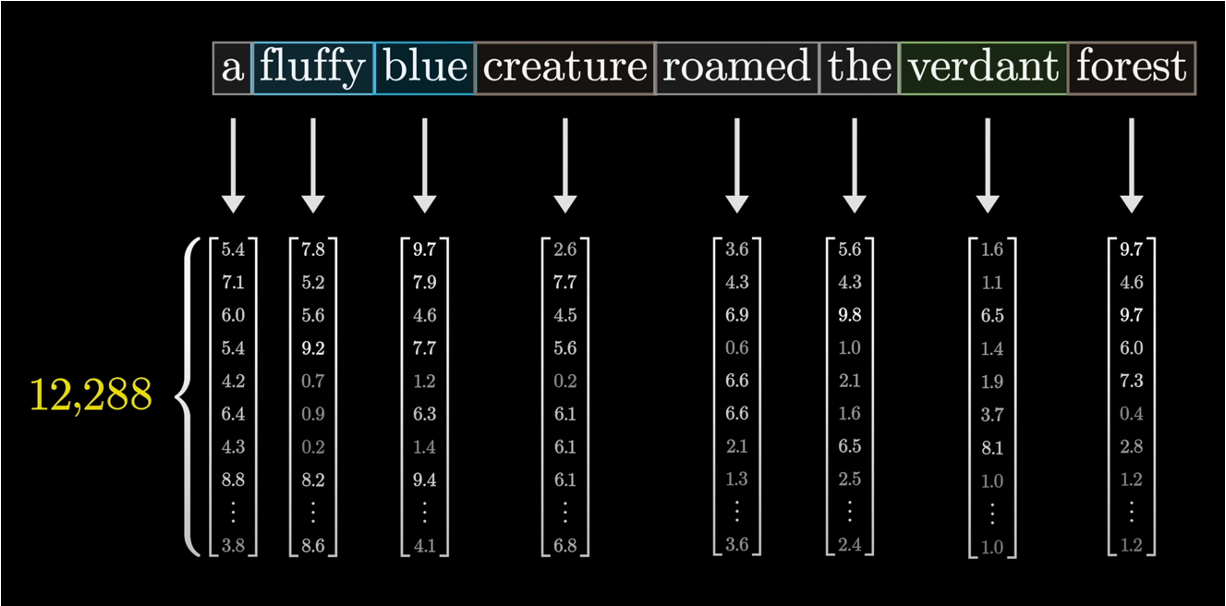

In [2]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
    
    def forward(self, x):
        output = self.embedding(x) * math.sqrt(self.d_model)
        print("\n=== Embedding输出 ===")
        print(f"形状: {output.shape}")
        print("前3个token的嵌入均值:", output[0, :3].mean().item())
        return output



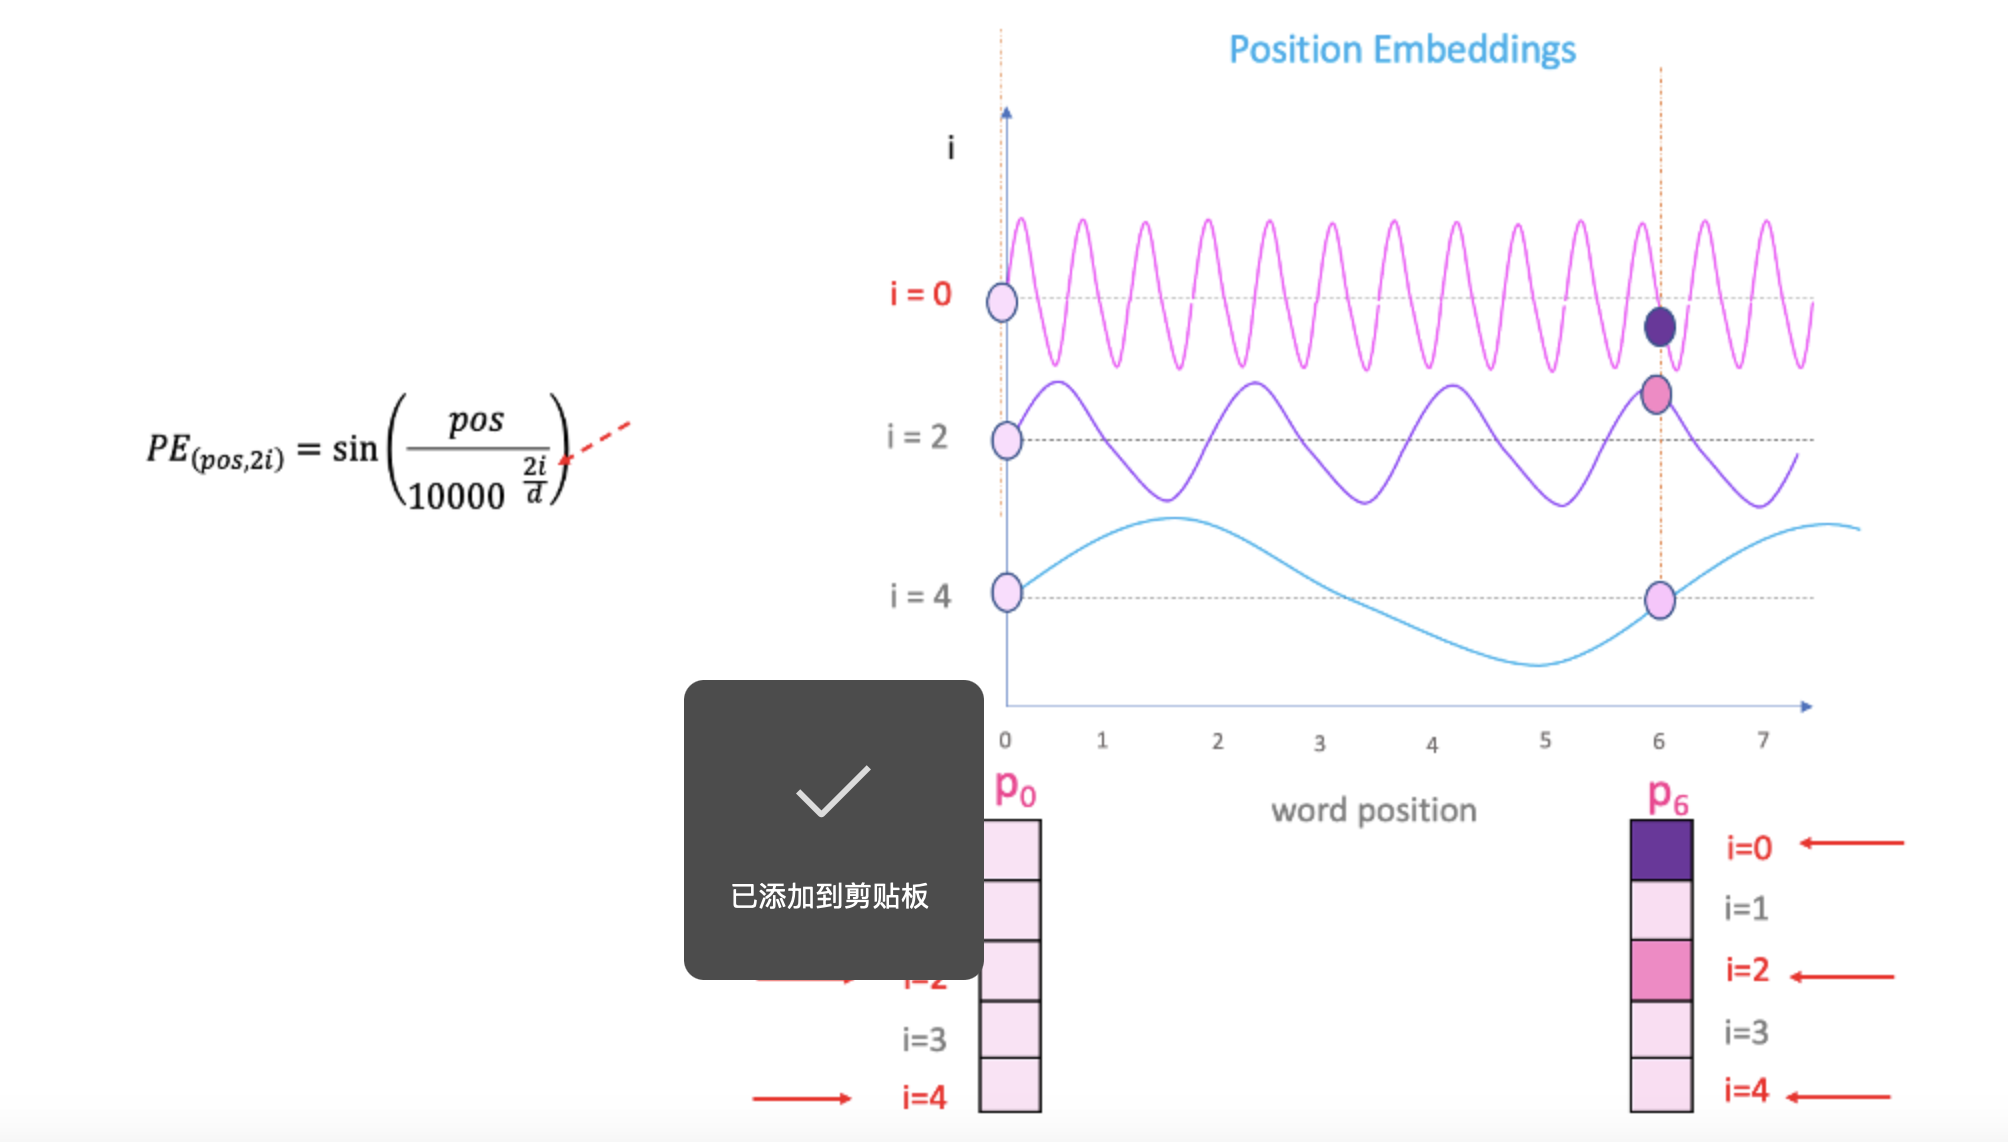

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        output = x + self.pe[:, :x.size(1)]
        print("\n=== 位置编码输出 ===")
        print(f"形状: {output.shape}")
        print("位置编码后的第一个token:", output[0, 0, :3].detach().numpy())
        return output



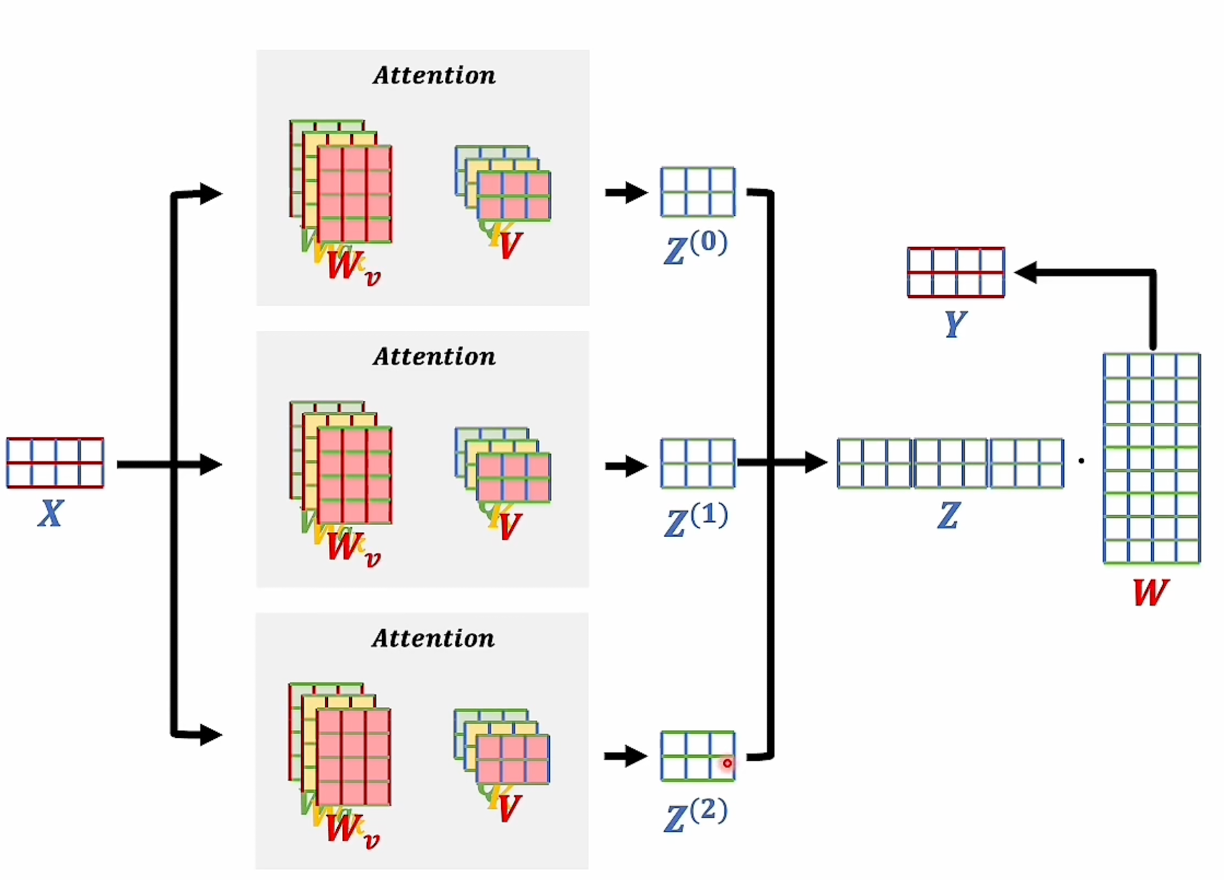

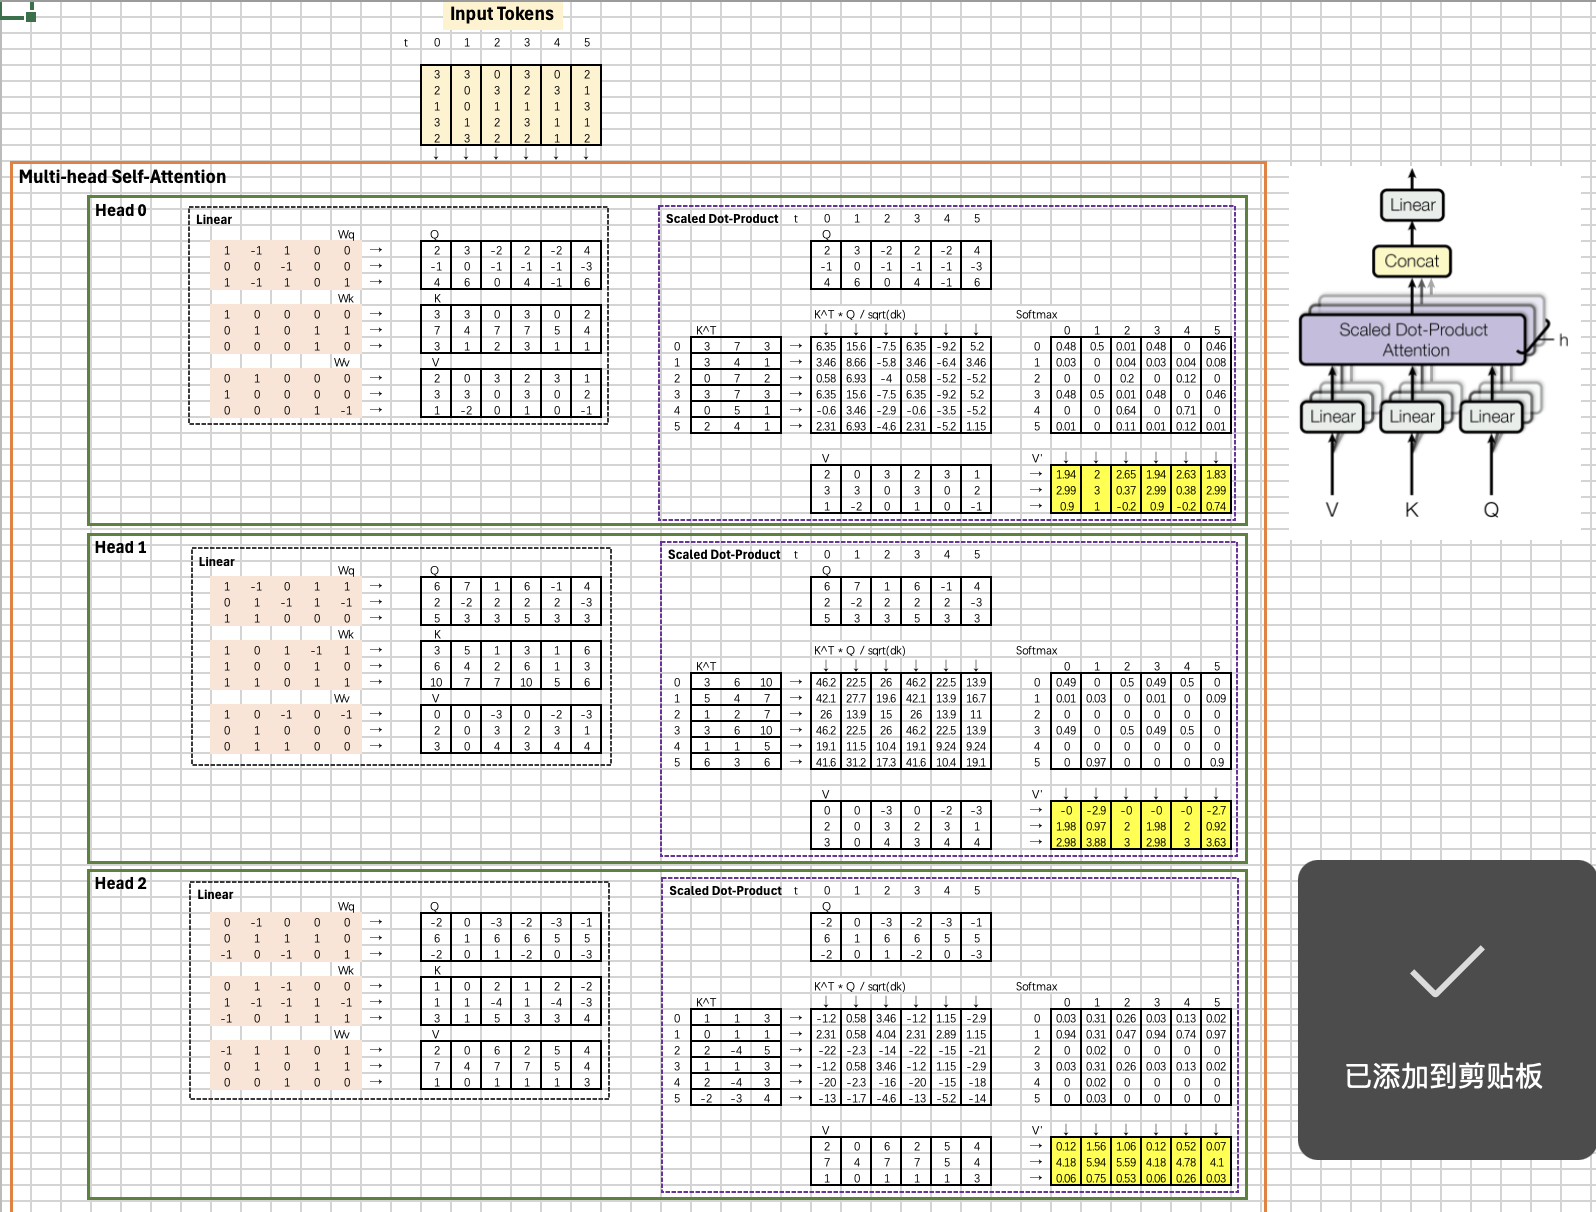

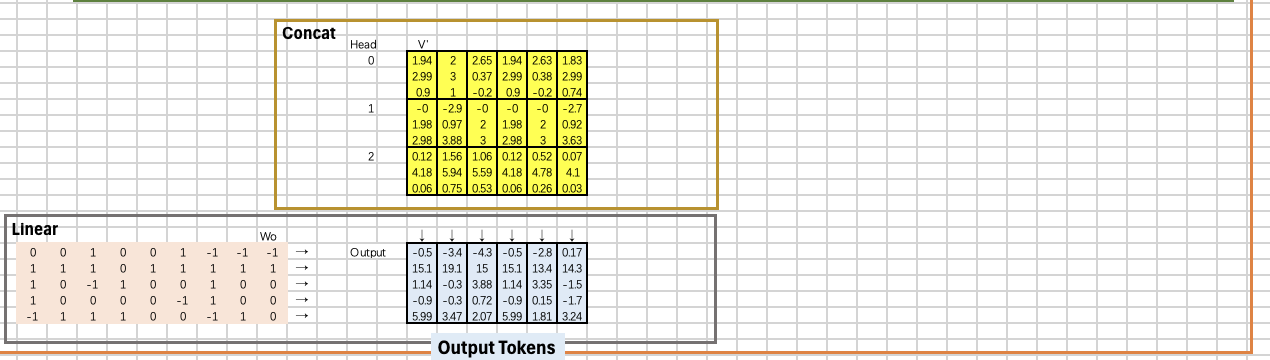

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.Wo = nn.Linear(d_model, d_model)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        
        # 分头处理
        Q = self.Wq(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.Wk(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.Wv(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 注意力计算
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        attn_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)
        
        # 合并多头
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.Wo(output)
        
        print("\n=== 多头注意力输出 ===")
        print(f"形状: {output.shape}")
        print("注意力权重均值:", attn_weights.mean().item())
        return output


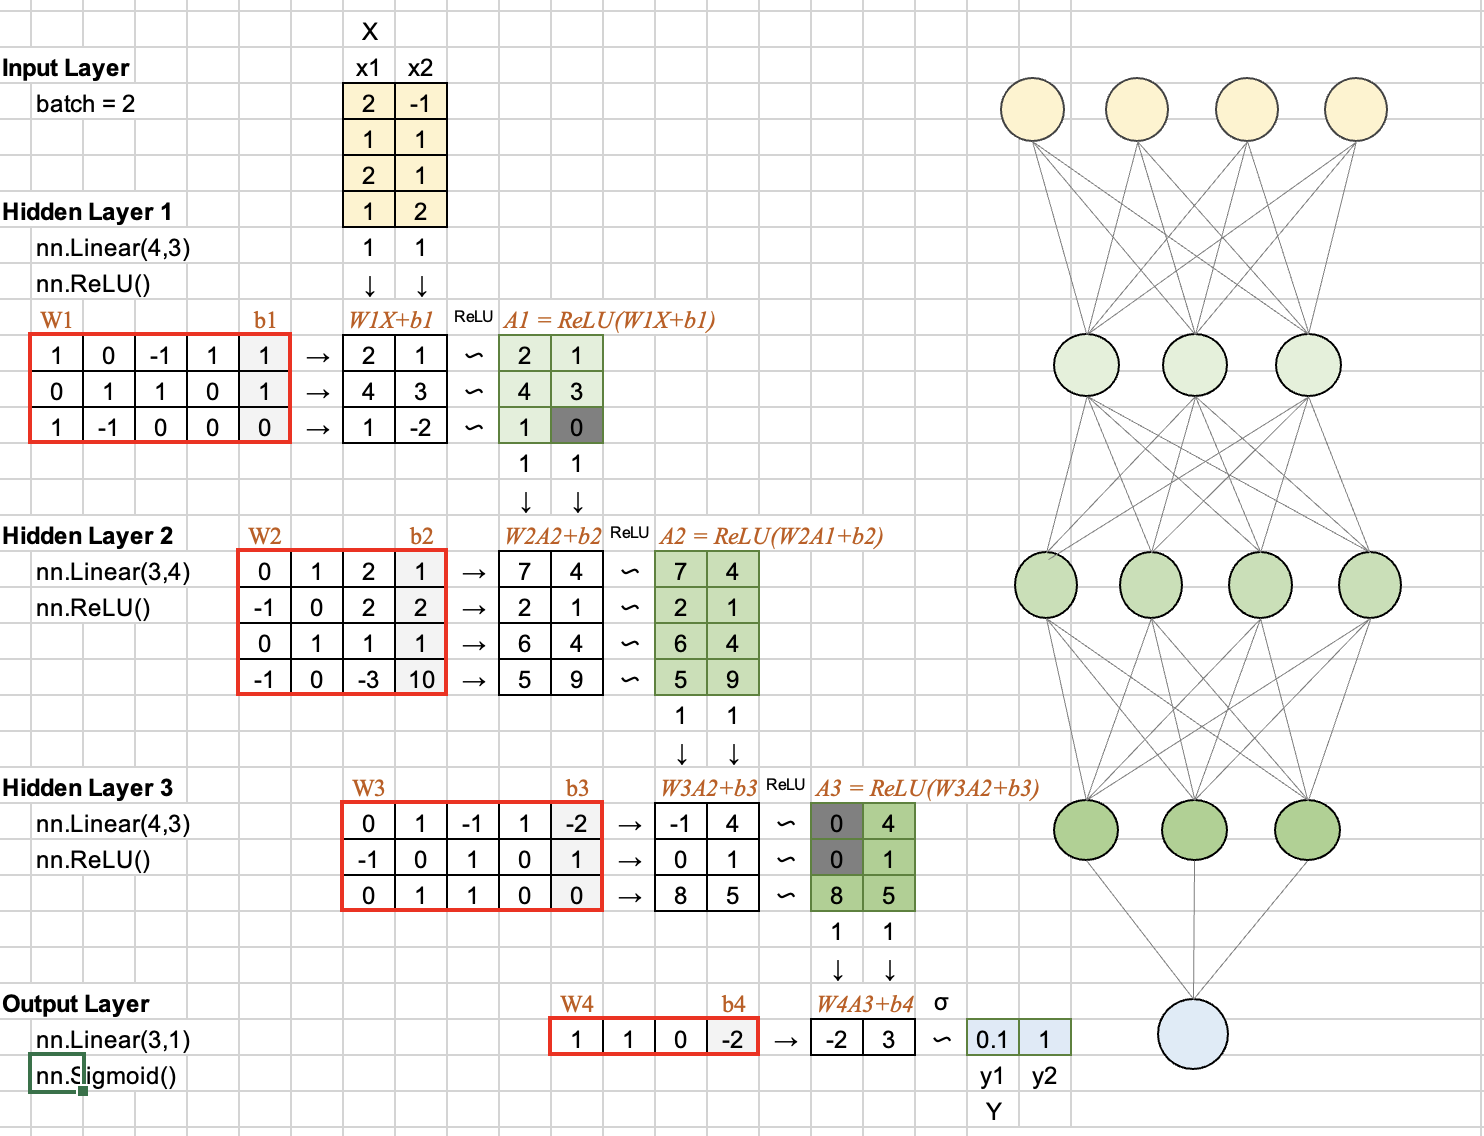

In [5]:
class FFN(nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        output = self.linear2(self.activation(self.linear1(x)))
        print("\n=== FFN输出 ===")
        print(f"形状: {output.shape}")
        print("FFN输出均值:", output.mean().item())
        return output

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = FFN(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        print("\n=== 编码器层开始 ===")
        # 注意力子层
        attn_output = self.self_attn(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))
        
        # FFN子层
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        print("编码器层输出均值:", x.mean().item())
        return x

class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff):
        super().__init__()
        self.embedding = Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.linear = nn.Linear(d_model, vocab_size)
    
    def forward(self, x):
        print("=== 输入序列 ===")
        print("Token IDs:", x.tolist()[0])
        
        x = self.embedding(x)
        x = self.pos_encoding(x)
        
        for i, layer in enumerate(self.layers):
            print(f"\n=== 第{i+1}层编码 ===")
            x = layer(x)
        
        logits = self.linear(x)
        print("\n=== 线性层输出 ===")
        print("形状:", logits.shape)
        print("logits示例:", logits[0, -1, :3].detach().numpy())
        
        return logits

In [6]:
# ====================== 3. 运行示例 ======================
if __name__ == "__main__":
    # 初始化BPE分词器
    corpus = "我 爱 学习 大 语言 模型"  # 训练数据
    bpe = SimpleBPE(corpus, vocab_size=20)
    
    # 编码输入文本
    input_text = "我爱学习大语言模型"
    input_ids = torch.tensor([bpe.encode(input_text)])
    
    print("=== BPE分词结果 ===")
    print("Tokenized IDs:", input_ids.tolist()[0])
    print("对应Tokens:", [bpe.id_to_token[i] for i in input_ids[0].tolist()])
    
    # 模型参数
    vocab_size = len(bpe.vocab)
    d_model = 64
    num_heads = 4
    num_layers = 2
    d_ff = 128
    
    # 初始化模型
    model = Transformer(vocab_size, d_model, num_heads, num_layers, d_ff)
    
    # 前向传播
    logits = model(input_ids)
    
    # 最终输出
    probs = torch.softmax(logits, dim=-1)
    print("\n=== 最终概率输出 ===")
    print("概率形状:", probs.shape)
    print("最后一个token的top3概率:", torch.topk(probs[0, -1], 3).values.tolist())

=== BPE分词结果 ===
Tokenized IDs: [15, 17, 14, 11, 13, 19, 18, 16, 12]
对应Tokens: ['我', '爱', '学', '习', '大', '语', '言', '模', '型']
=== 输入序列 ===
Token IDs: [15, 17, 14, 11, 13, 19, 18, 16, 12]

=== Embedding输出 ===
形状: torch.Size([1, 9, 64])
前3个token的嵌入均值: 0.2311757653951645

=== 位置编码输出 ===
形状: torch.Size([1, 9, 64])
位置编码后的第一个token: [-10.06681   10.902101  -9.071343]

=== 第1层编码 ===

=== 编码器层开始 ===

=== 多头注意力输出 ===
形状: torch.Size([1, 9, 64])
注意力权重均值: 0.1111111119389534

=== FFN输出 ===
形状: torch.Size([1, 9, 64])
FFN输出均值: -0.039838775992393494
编码器层输出均值: -9.934107758624577e-09

=== 第2层编码 ===

=== 编码器层开始 ===

=== 多头注意力输出 ===
形状: torch.Size([1, 9, 64])
注意力权重均值: 0.1111111119389534

=== FFN输出 ===
形状: torch.Size([1, 9, 64])
FFN输出均值: 0.006978346034884453
编码器层输出均值: 8.278423280216884e-09

=== 线性层输出 ===
形状: torch.Size([1, 9, 20])
logits示例: [-0.4299276  -1.0845197  -0.73455274]

=== 最终概率输出 ===
概率形状: torch.Size([1, 9, 20])
最后一个token的top3概率: [0.10207919776439667, 0.0902925655245781, 0.08149108290672302]
